In [5]:
# ! pip install opencv-python

## Load Datasets 

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import time


In [3]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import sys 
from tensorflow import keras 
from keras.models import Sequential 
from keras.applications.vgg16 import VGG16


### Data Preprocessing 

In [4]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'train_data\\images\\{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('train_data\\clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('train_data\\noisy_labels.csv', delimiter=',', dtype="int8")

Class: <class 'numpy.ndarray'>
Dimensions: (32, 32, 3)
Data Type: uint8
Head: [[[63 62 59]
  [45 46 43]
  [43 48 50]]

 [[20 20 16]
  [ 0  0  0]
  [ 0  8 18]]

 [[21 24 25]
  [ 0  7 16]
  [ 8 27 49]]]
Range 0 255


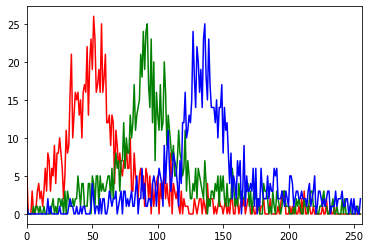

In [5]:
# example of data info 
file_path = "train_data\\images\\00001.png"
img = cv2.imread(file_path)
print('Class:', type(img))
print('Dimensions:', img.shape)
print('Data Type:', img.dtype)
print('Head:', img[:3, :3])
print('Range', np.min(img), np.max(img))

color = ('r', 'g','b')
for i, col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


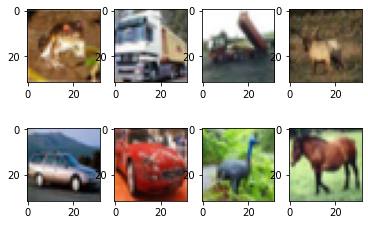

In [6]:
# [DO NOT MODIFY THIS CELL]

# visualize
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## Predictive Model 
We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### Baseline Model: Logistic Regression 

In [7]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [8]:
feature_mtx
# len(feature_mtx)

array([[ 19., 102., 619., ...,  84.,  42.,  15.],
       [ 98., 301., 233., ..., 316., 200., 146.],
       [127., 405., 130., ..., 105.,  37., 306.],
       ...,
       [450., 268., 106., ..., 117.,  78., 285.],
       [ 45.,  80., 278., ..., 166., 291., 434.],
       [ 55., 193., 376., ..., 364., 150., 165.]])

In [9]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [10]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### Model I: CNN

In [11]:
# Assign Required Variables
X_train = tf.cast(imgs, dtype='float32')/255.0
y_train = tf.one_hot(noisy_labels, depth=10)
X_test = tf.cast(imgs[:10000], dtype='float32')/255.0
X_test_img = imgs[:10000]
y_test = tf.one_hot(clean_labels, depth = 10)

In [12]:
# X_train.shape

In [20]:
model1 = keras.Sequential([ 
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), 
                        strides=1, padding='same',
                        input_shape=(32,32,3), use_bias=False), 
    # keras.layers.BatchNormalization(), 
    keras.layers.Activation('relu'), 
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid'), 
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), 
                       strides=1, padding='same', use_bias=False), 
    # keras.layers.BatchNormalization(), 
    keras.layers.Activation('relu'), 
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid'), 
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), 
                       strides=1, padding='same', use_bias=False), 
    keras.layers.Activation('relu'), 
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid'), 
    keras.layers.Dropout(0.2), 
    
    keras.layers.Flatten(), 
    keras.layers.Dense(64, use_bias=False), 
    keras.layers.Activation('relu'), 
    keras.layers.Dense(10, activation='softmax') 
]) 

# BatchNormalization here might decrease the accuracy?

In [21]:
# categorical cross entropy due to one hot
model1.compile(optimizer = tf.keras.optimizers.Adam(0.001),
             loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy'])

In [22]:
%%time 

# 80 epochs 
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
model1.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
625/625 [==============================] - 45s 70ms/step - loss: 2.2917 - accuracy: 0.1288 - val_loss: 2.2662 - val_accuracy: 0.1661
Epoch 2/100
625/625 [==============================] - 43s 68ms/step - loss: 2.2516 - accuracy: 0.1761 - val_loss: 2.2351 - val_accuracy: 0.1974
Epoch 3/100
625/625 [==============================] - 48s 76ms/step - loss: 2.2323 - accuracy: 0.2007 - val_loss: 2.2259 - val_accuracy: 0.2035
Epoch 4/100
625/625 [==============================] - 58s 92ms/step - loss: 2.2181 - accuracy: 0.2144 - val_loss: 2.2210 - val_accuracy: 0.2218
Epoch 5/100
625/625 [==============================] - 60s 96ms/step - loss: 2.2043 - accuracy: 0.2237 - val_loss: 2.2061 - val_accuracy: 0.2296
Epoch 6/100
625/625 [==============================] - 58s 92ms/step - loss: 2.1919 - accuracy: 0.2350 - val_loss: 2.2098 - val_accuracy: 0.2275
Epoch 7/100
625/625 [==============================] - 51s 82ms/step - loss: 2.1766 - accuracy: 0.2438 - val_loss: 2.2083 - val_ac

625/625 [==============================] - 57s 92ms/step - loss: 1.7214 - accuracy: 0.4087 - val_loss: 2.4524 - val_accuracy: 0.1952
Epoch 58/100
625/625 [==============================] - 54s 86ms/step - loss: 1.7130 - accuracy: 0.4128 - val_loss: 2.4537 - val_accuracy: 0.2031
Epoch 59/100
625/625 [==============================] - 54s 87ms/step - loss: 1.7086 - accuracy: 0.4171 - val_loss: 2.4635 - val_accuracy: 0.2051
Epoch 60/100
625/625 [==============================] - 54s 87ms/step - loss: 1.7019 - accuracy: 0.4143 - val_loss: 2.4799 - val_accuracy: 0.1999
Epoch 61/100
625/625 [==============================] - 54s 87ms/step - loss: 1.6925 - accuracy: 0.4190 - val_loss: 2.4951 - val_accuracy: 0.2042
Epoch 62/100
625/625 [==============================] - 55s 88ms/step - loss: 1.6898 - accuracy: 0.4234 - val_loss: 2.4771 - val_accuracy: 0.2050
Epoch 63/100
625/625 [==============================] - 54s 86ms/step - loss: 1.6876 - accuracy: 0.4223 - val_loss: 2.4766 - val_accuracy

### Model II: VGG16

In [13]:
vgg = VGG16(input_shape=(32,32,3), include_top=False, weights='imagenet')

In [14]:
vgg.trainable = False
model2 = keras.Sequential([
    vgg, 
    keras.layers.GlobalAveragePooling2D(), 
    keras.layers.Dense(10, activation='softmax')    
])


In [15]:
# categorical cross entropy due to one hot
model2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
             loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy'])

In [16]:
%%time 

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model2.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=64, callbacks=[early_stopping])

Epoch 1/5
1250/1250 [==============================] - 267s 213ms/step - loss: 2.2518 - accuracy: 0.1898 - val_loss: 2.2331 - val_accuracy: 0.2140
Epoch 2/5
1250/1250 [==============================] - 308s 246ms/step - loss: 2.2115 - accuracy: 0.2254 - val_loss: 2.2303 - val_accuracy: 0.2191
Epoch 3/5
1250/1250 [==============================] - 286s 229ms/step - loss: 2.1975 - accuracy: 0.2363 - val_loss: 2.2234 - val_accuracy: 0.2231
Epoch 4/5
1250/1250 [==============================] - 290s 232ms/step - loss: 2.1885 - accuracy: 0.2410 - val_loss: 2.2213 - val_accuracy: 0.2283
Epoch 5/5
1250/1250 [==============================] - 284s 227ms/step - loss: 2.1817 - accuracy: 0.2461 - val_loss: 2.2214 - val_accuracy: 0.2321
Wall time: 23min 58s


### Model III: ResNet

In [26]:
resnet = keras.applications.resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_shape=(32,32,3))

171450368/171446536 [==============================] - 28s 0us/step


In [30]:
resnet.trainable = False
model3 = keras.Sequential([
    resnet, 
    keras.layers.GlobalAveragePooling2D(), 
    keras.layers.Dense(10, activation='softmax')    
])

In [31]:
model3.compile(optimizer = tf.keras.optimizers.Adam(0.001),
             loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy'])

In [32]:
%%time 

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
model3.fit(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/5
1250/1250 [==============================] - 305s 237ms/step - loss: 2.3123 - accuracy: 0.1135 - val_loss: 2.3133 - val_accuracy: 0.1126
Epoch 2/5
1250/1250 [==============================] - 367s 294ms/step - loss: 2.3016 - accuracy: 0.1223 - val_loss: 2.2859 - val_accuracy: 0.1430
Epoch 3/5
1250/1250 [==============================] - 401s 321ms/step - loss: 2.2969 - accuracy: 0.1268 - val_loss: 2.3214 - val_accuracy: 0.1403
Epoch 4/5
1250/1250 [==============================] - 364s 291ms/step - loss: 2.2938 - accuracy: 0.1338 - val_loss: 2.2844 - val_accuracy: 0.1432
Epoch 5/5
1250/1250 [==============================] - 378s 303ms/step - loss: 2.2916 - accuracy: 0.1356 - val_loss: 2.2928 - val_accuracy: 0.1395
Wall time: 30min 15s


## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
## [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.